# Exercise 3: Interatomic potentials

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import sympy as sp

from matplotlib import colormaps  # For colormap access
from matplotlib.colors import Normalize  # For color normalization

# Access the colormap (e.g., viridis)
cmap = colormaps['viridis']

# a) Interatomic potential shape

<span style="color:green; font-variant:small-caps;">(PEN & PAPER)</span> Sketch a typical interatomic potential (energy as a function of interatomic distance $r$) and explain your choices. What are the key contributions to this potential? In particular, what is the behavior as $r \to 0$ and $r \to +\infty$?

---

## The Stillinger-Weber (SW) potential for Si

The **Stillinger–Weber (SW) potential** for silicon was the first practical cluster potential to reproduce the **diamond cubic structure** as the most stable configuration. It captures not only the correct equilibrium bond lengths and angles but also accurately reflects the **energetic cost of distorting** the tetrahedral geometry, making it a foundational model for covalent systems.

Originally designed for **silicon**, the Stillinger–Weber potential uses the form:

#### Two-body term:
$$
v_2(r) = A \varepsilon \left[ B \left( \frac{\sigma}{r} \right)^p - \left( \frac{\sigma}{r} \right)^q \right] \exp\left( \frac{\sigma}{r - a\sigma} \right)
$$

**The exponential function is added to introduce a cutoff radius ($r_{\mathrm{cut}} = a \sigma$) while mantaining the function smooth and continuous.**

#### Three-body term:
$$
v_3(r_{ij}, r_{ik}, \theta) = \lambda \varepsilon \left[ \cos \theta - \cos \theta_0 \right]^2 \exp\left( \frac{\gamma \sigma}{r_{ij} - a\sigma} \right) \exp\left( \frac{\gamma \sigma}{r_{ik} - a\sigma} \right)
$$

- $r_{ij}, r_{ik}$ are pair distances
- $\theta$ is the angle $\angle jik$
- $\cos \theta_0$ defines the preferred bond angle (e.g., tetrahedral for silicon)

The **three-body term** contains an angular component of the form:

$$
\left( \cos \theta_{jik} + \frac{1}{3} \right)^2
$$

This function is minimized when $\cos \theta = -\frac{1}{3}$, corresponding to the **tetrahedral angle** $\theta \approx 109.47^\circ$. As a result, the potential energetically favors tetrahedral coordination and stabilizes the **diamond cubic lattice** found in silicon.

The original parameters determined by Stillinger and Weber are:

| Parameter | Value        | Unit |
|-----------|--------------|------|
| $\sigma$     | 2.0951       | $\mathrm{\AA}$    |
| $\varepsilon$   | 2.1682       | eV   |
| A         | 7.049556277  | —    |
| B         | 0.6022245584 | —    |
| p         | 4            | —    |
| q         | 0            | —    |
| a         | 1.8          | —    |
| $\lambda$ | 21.0          | — |
| $\gamma$ | 1.2          | — |


### Only two-body term:
Assuming ideal bond angles, **we restrict our model to the two-body interaction term**.  

Let's plot it and see what it looks like.

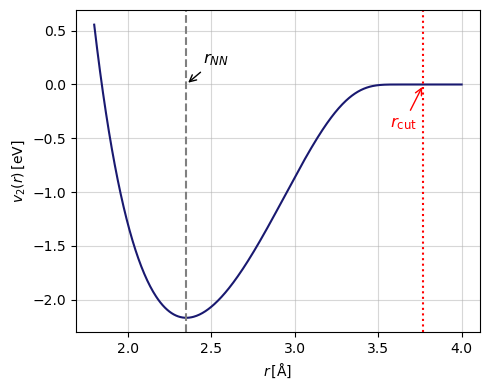

In [8]:
# SW potential parameters
A = 7.049556277
B = 0.6022245584
p = 4
q = 0
a = 1.8 
sigma = 2.0951  # Ångstroms
epsilon = 2.1682  # eV

# Define v2(r)
def v2_real_func(r):
    r_red = r / sigma
    if r >= a * sigma:
        return 0.0
    return epsilon * A * (B * r_red**(-p) - r_red**(-q)) * np.exp(1 / (r_red - a))

# Compute data
r_vals_real = np.linspace(1.8, 4.0, 500)
v2_vals = [v2_real_func(r) for r in r_vals_real]

# Important distances
r_NN = 2.35
r_cut = a * sigma

# Plot
plt.figure(figsize=(5, 4))
plt.plot(r_vals_real, v2_vals, color='midnightblue')

# Vertical lines
plt.axvline(x=r_NN, color='gray', linestyle='--')
plt.axvline(x=r_cut, color='red', linestyle=':')

# Annotations
plt.annotate(r'$r_{NN}$', xy=(r_NN, 0), xytext=(r_NN + 0.1, 0.2),
             arrowprops=dict(arrowstyle='->'), fontsize=12)

plt.annotate(fr'$r_{{\mathrm{{cut}}}}$', 
             xy=(r_cut, 0), xytext=(r_cut - 0.2, -0.4),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=12, color='red')

# Axes
plt.xlabel(r'$r\,\mathrm{[\AA]}$')
plt.ylabel(r'$v_2(r)\,\mathrm{[eV]}$')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

---

# b) Parameters and force
- <span style="color:green; font-variant:small-caps;">(PEN & PAPER)</span> What is the relationship between the parameter $\varepsilon$ and the depth of the potential well? Illustrate qualitatively how the shape of the potential changes as 
$\varepsilon$ varies.  
  -  Hint: You can change `epsilon` in the previous code snippet and see how the plot changes.

- <span style="color:green; font-variant:small-caps;">(PEN & PAPER)</span> Given the shape of the two-body term in the Stillinger-Weber potential, sketch the corresponding force $F(r)$ as a function of distance $r$. What is the relationship between force and potential?

- <span style="color:blue; font-variant:small-caps;">(PYTHON)</span> By setting the interatomic force to zero, we determine the distance $r_{ij}$ at which the potential reaches its minimum. This distance corresponds to the equilibrium bond length between first neighbors. Run the code and compare your result to the experimental value of $2.35\,\text{\AA}$.

- <span style="color:blue; font-variant:small-caps;">(PYTHON)</span> Next, evaluate `v2_real_func` at `r_min` to obtain the energy at the minimum: do you recognize the value?.

- <span style="color:violet; font-variant:small-caps;">(OPTIONAL)</span> Use the function that calculates the force to plot $F(r)$


rNN = 2.3517 Å
v2(rNN) = -2.1682 eV


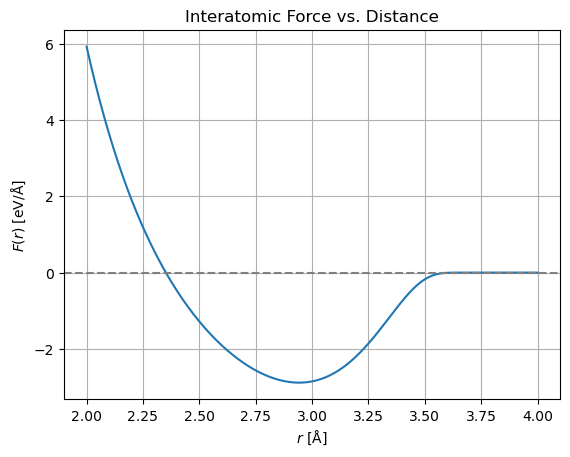

In [10]:
# Define numerical derivative: force = -dv2/dr
def force_real_func(r, h=1e-6):
    return -(v2_real_func(r + h) - v2_real_func(r - h)) / (2 * h)

# Use minimize_scalar on |force| to find the root of the force
force_root_result = minimize_scalar(lambda r: abs(force_real_func(r)),
                                    bounds=(2.0, a * sigma - 1e-4),
                                    method='bounded')

r_NN = force_root_result.x if force_root_result.success else None

print(f'rNN = {r_NN:.4f} Å')

E_min = v2_real_func(r_NN)
print(f'v2(rNN) = {E_min:.4f} eV')

r_vals = np.linspace(2.0, 4.0, 500)
F_vals = [force_real_func(r) for r in r_vals]

plt.figure()
plt.plot(r_vals, F_vals)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel(r'$r$ [Å]')
plt.ylabel(r'$F(r)$ [eV/Å]')
plt.title('Interatomic Force vs. Distance')
plt.grid(True)
plt.show()

---

# c) Lattice constant 

<span style="color:green; font-variant:small-caps;">(PEN & PAPER)</span> Use the nearest-neighbor distance to calculate the lattice constant, taking into account the crystal structure of silicon.

---

# d) Counting interactions

<span style="color:green; font-variant:small-caps;">(PEN & PAPER)</span> Based on your calculations and the given parameters, determine the number of neighboring atomic shells included within the Stillinger–Weber potential cutoff radius.

---

# e) Compute energy per atom

- <span style="color:green; font-variant:small-caps;">(PEN & PAPER)</span> Compute the energy per atom by considering only first-neighbor interactions and neglecting any angular (directional bonding) contributions.

- <span style="color:blue; font-variant:small-caps;">(PYTHON)</span> From this, we can compute the equation of state $E(V)$, which describes how the total energy per atom varies with the atomic volume. In practice, this involves sweeping over different values of the lattice parameter, since the volume of the unit cell (and hence the volume per atom) depends directly on the lattice parameter. For each value of the lattice parameter $a_0$, we calculate the corresponding energy per atom considering that for the diamond cubic structure, the unit cell is cubic and contains 8 atoms.

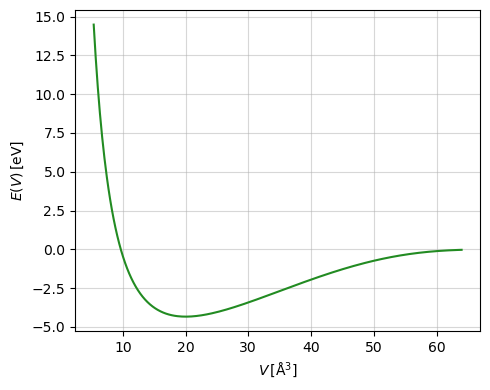

Equilibrium a0 = 5.4221 Å
Equilibrium volume per atom = 19.9258 Å³
Minimum energy per atom = -4.3362 eV


In [11]:
def energy_per_atom_NN(a0):
    r_NN = (np.sqrt(3) / 4) * a0         # Nearest-neighbor distance from lattice parameter
    v = v2_real_func(r_NN)               # Pair potential energy at r_NN
    z = 4                                # Each atom has 4 neighbors in diamond cubic
    return 0.5 * z * v                   # Multiply by 1/2 to avoid double counting

a0_vals = np.linspace(3.5, 8.0, 200)  
volumes = (a0_vals ** 3) / 8             # bcs there are 8 atoms per unit cell
energies_NN = [energy_per_atom_NN(a0) for a0 in a0_vals]

# Plot E(V)
plt.figure(figsize=(5, 4))
plt.plot(volumes, energies_NN, color='forestgreen')
plt.xlabel(r'$V\,\mathrm{[\AA^3]}$')
plt.ylabel(r'$E(V)\,\mathrm{[eV]}$')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

min_idx = np.argmin(energies_NN)
V_eq = volumes[min_idx]
E_eq = energies_NN[min_idx]
a_eq = a0_vals[min_idx]
print(f"Equilibrium a0 = {a_eq:.4f} Å")
print(f"Equilibrium volume per atom = {V_eq:.4f} Å³")
print(f"Minimum energy per atom = {E_eq:.4f} eV")

---

## f) Include second neighbors in the cutoff

<span style="color:blue; font-variant:small-caps;">(PYTHON)</span> Define a new cutoff value `a_modified` in the range $1.80 <$ `a_modified` $< 2.14$ to ensure that second-nearest neighbor interactions are included.


- Plot both the pair potential and the equation of state with the new cutoff.

- Compare them to the original curves. How do the shapes of the curves depend on the cutoff? 

- What changes? Why? Briefly explain. 

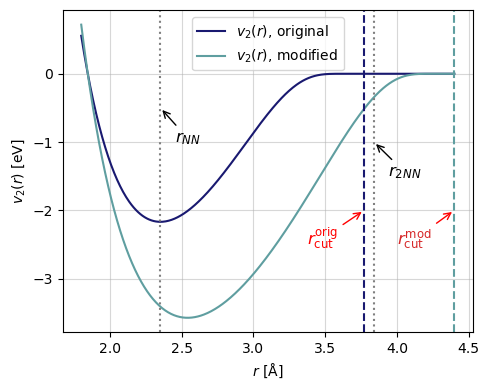

In [12]:
# Cutoff values
a_original = 1.8
a_modified = 2.1 # new cutoff value

# Define v2 as a function of cutoff
def v2(r, a_cut):
    r_red = r / sigma
    if r >= a_cut * sigma:
        return 0.0
    return epsilon * A * (B * r_red**(-p) - r_red**(-q)) * np.exp(1 / (r_red - a_cut))

# Distance values
r_vals = np.linspace(1.8, a_modified * sigma - 1e-4, 500)
v2_vals_orig = [v2(r, a_original) for r in r_vals]
v2_vals_mod = [v2(r, a_modified) for r in r_vals]

# Important distances
r_NN = 2.3517
r_2NN = 3.84
r_cut_orig = a_original * sigma
r_cut_mod = a_modified * sigma

# Plot
plt.figure(figsize=(5, 4))
plt.plot(r_vals, v2_vals_orig, color='midnightblue', label=r'$v_2(r)$, original')
plt.plot(r_vals, v2_vals_mod, color='cadetblue', lw=1.5, label=r'$v_2(r)$, modified')

# Vertical lines
plt.axvline(x=r_NN, color='gray', linestyle=':')
plt.axvline(x=r_2NN, color='gray', linestyle=':')
plt.axvline(x=r_cut_orig, color='midnightblue', linestyle='--')
plt.axvline(x=r_cut_mod, color='cadetblue', linestyle='--')

# Annotations
plt.annotate(r'$r_{NN}$', xy=(r_NN, -0.5), xytext=(r_NN + 0.1, -1),
             arrowprops=dict(arrowstyle='->'), fontsize=12)
plt.annotate(r'$r_{2NN}$', xy=(r_2NN, -1), xytext=(r_2NN + 0.1, -1.5),
             arrowprops=dict(arrowstyle='->'), fontsize=12)
plt.annotate(fr'$r^{{\mathrm{{orig}}}}_{{\mathrm{{cut}}}}$', 
             xy=(r_cut_orig, -2), xytext=(r_cut_orig - 0.4, -2.5),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=12, color='red')
plt.annotate(fr'$r^{{\mathrm{{mod}}}}_{{\mathrm{{cut}}}}$', 
             xy=(r_cut_mod, -2), xytext=(r_cut_mod - 0.4, -2.5),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=12, color='tab:red')

# Axes
plt.xlabel(r'$r\ \mathrm{[\AA]}$')
plt.ylabel(r'$v_2(r)\ \mathrm{[eV]}$')
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

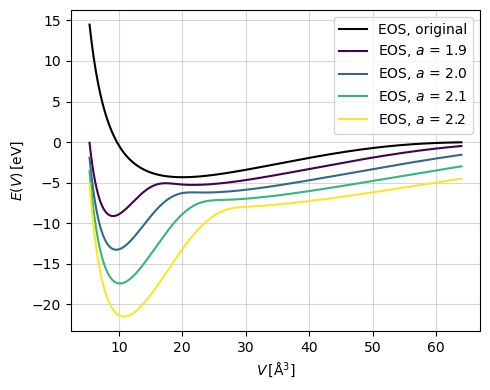

In [15]:
# Energy per atom including 2nd nearest neighbors
def energy_per_atom_2NN(a0, a_cutoff):
    r_NN = (np.sqrt(3) / 4) * a0
    r_2NN = a0 / np.sqrt(2)

    v_NN = v2(r_NN, a_cutoff)
    v_2NN = v2(r_2NN, a_cutoff)

    z1 = 4   # number of 1st neighbors in diamond cubic
    z2 = 12  # number of 2nd neighbors

    return 0.5 * (z1 * v_NN + z2 * v_2NN)

# Volume per atom in diamond cubic
def volume_per_atom(a0):
    return a0**3 / 8

# Lattice parameter sweep
a0_vals = np.linspace(3.5, 8.0, 200)
volumes = [volume_per_atom(a0) for a0 in a0_vals]

# Cutoff values to explore
cutoff_vals = np.arange(1.9, 2.2, 0.1)
energy_curves = {}

# Normalize colormap over range of cutoff values
norm = Normalize(vmin=cutoff_vals.min(), vmax=cutoff_vals.max())

# Compute energy curves
for a_cutoff in cutoff_vals:
    energies = [energy_per_atom_2NN(a0, a_cutoff) for a0 in a0_vals]
    energy_curves[a_cutoff] = energies

# Plot E(V)
plt.figure(figsize=(5, 4))

# Original (first-neighbor) curve
plt.plot(volumes, energies_NN, color='black', label='EOS, original')

# 2NN curves with Viridis colormap
for a_cutoff in cutoff_vals:
    color = colormaps['viridis'](norm(a_cutoff))
    plt.plot(volumes, energy_curves[a_cutoff], label=f'EOS, $a$ = {a_cutoff:.1f}', color=color)

plt.xlabel(r'$V\,\mathrm{[\AA^3]}$')
plt.ylabel(r'$E(V)\,\mathrm{[eV]}$')
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()